# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 


## Homework 9:  ANNs


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader<br/>


<hr style="height:2pt">



In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

Import libraries:

In [42]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale

import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from keras import regularizers


from sklearn.utils import shuffle

<hr style='height:2pt'>
<div class='theme'> Neural Networks </div> 

Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here we'll focus on the key idea of NNs: they are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size). We'll also partially explore what patterns the neural network learns and how well they generalize.

In this question we'll see if Neural Networks can learn a (limited) version of the Fourier Transform. (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In symbols: $ \cal{F(s)} = \int_{-\infty}^\infty f(x)e^{- i xs}dx$. In words, the value of the transformed function at some point, $s$, is the value of an integral which measures, in some sense, how much the original f(x) looks like a wave with period s. As an example, with $f(x) = 4cos(x) + sin(2x)$,  $\cal{F}(s)$ is 0 everywhere except at -2, -1, 1, and 2, mapping to the waves of period 1 and 1/2. The values at these points are linked to the magnitude of the waves, and their phases (roughly: sin waves versus cosine waves).

The only thing about the Fourier transform that matters for this pset is this: function goes in, re-write in terms of sine and cosine comes out.

In our specific problem, we'll train a network to map from 1000 sample values from a function (equally spaced along 0 to 2$\pi$) to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our X_train dataset is thus N by 1000 and our y_train is N by 4.

Questions 1.1 and 1.2 will get you used to the format of the data.

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 by 1,000) and (10,000 by 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 by 1,000) and (2,000 by 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 by 1,000) and (9 by 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

<div class='exercise'> <b> Question 1 [50pts] <b> </div>
**1.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve.

**1.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

**1.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

**1.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**1.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of 0.2. You can train for longer if you wish- the fit tends to improve over time.

**1.6** Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefficients that generated the data?

**1.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

**1.8** Is there something that stands out about the difficult examples, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

**Hint**:
- Keras's documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [3]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a Keras or SKlearn model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [4]:
X_train = np.load('data/sinewaves_X_train.npy')
y_train = np.load('data/sinewaves_y_train.npy')

X_test = np.load('data/sinewaves_X_test.npy')
y_test = np.load('data/sinewaves_y_test.npy')

X_extended_test = np.load('data/sinewaves_X_extended_test.npy')
y_extended_test = np.load('data/sinewaves_y_extended_test.npy')

### Answers:  

**1.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

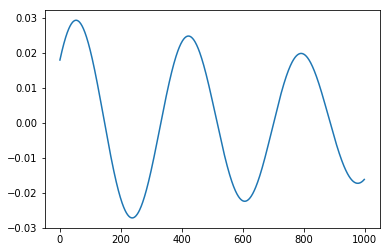

In [5]:
# your code here
plt.plot(X_train[0,:]);

**1.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$...

In [6]:
# your code here
y_train[0,:]

array([0.024, 0.533, 0.018, 0.558])

False

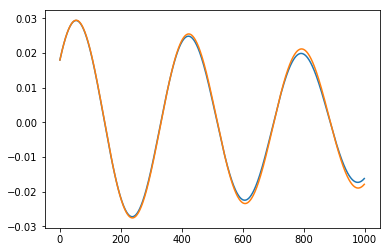

In [7]:
x_points = np.linspace(0,10*np.pi,1000)
train_from_test = 0.024*np.sin(0.533*x_points) + 0.018*np.cos(0.555*x_points)
plt.plot(X_train[0,:])
plt.plot(train_from_test)
np.all(X_train[0,:]==train_from_test)

**1.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

In [9]:
# your code here
model = Sequential([
    Dense(200, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(4, activation='linear')
])

**1.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

In [10]:
# your code here
model.compile(loss='mean_absolute_error', 
              optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               200200    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 204       
Total params: 225,554
Trainable params: 225,554
Non-trainable params: 0
_________________________________________________________________


----
Your answer here

----

**1.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of .2. You can train for longer if you wish- the fit tends to improve over time.

In [14]:
# your code here
model.fit(X_train, y_train, 
          epochs=50, 
          batch_size=32, 
          validation_split=.2,
          verbose=1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 1s 85us/step - loss: 0.0204 - val_loss: 0.0227
Epoch 2/50
8000/8000 [==============================] - 1s 85us/step - loss: 0.0214 - val_loss: 0.0236
Epoch 3/50
8000/8000 [==============================] - 1s 87us/step - loss: 0.0207 - val_loss: 0.0234
Epoch 4/50
8000/8000 [==============================] - 1s 88us/step - loss: 0.0209 - val_loss: 0.0241
Epoch 5/50
8000/8000 [==============================] - 1s 82us/step - loss: 0.0210 - val_loss: 0.0211
Epoch 6/50
8000/8000 [==============================] - 1s 102us/step - loss: 0.0207 - val_loss: 0.0242
Epoch 7/50
8000/8000 [==============================] - 1s 80us/step - loss: 0.0211 - val_loss: 0.0241
Epoch 8/50
8000/8000 [==============================] - 1s 85us/step - loss: 0.0210 - val_loss: 0.0225
Epoch 9/50
8000/8000 [==============================] - 1s 79us/step - loss: 0.0208 - val_loss: 0.0218
Epoch 10/50
8000/8000 [=

**1.6** Use the `plot_predictions` function to plot the model's predictions on `X-test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

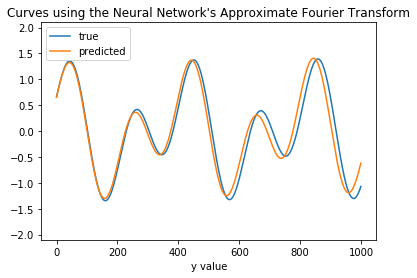

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.82790416 1.00034    0.65585595 0.4908258 ]


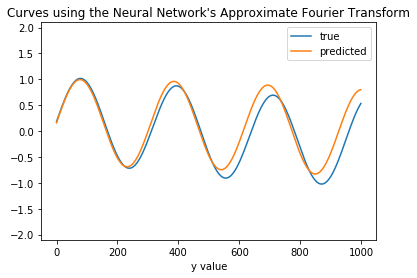

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.8363843  0.6475912  0.15980902 0.05688812]


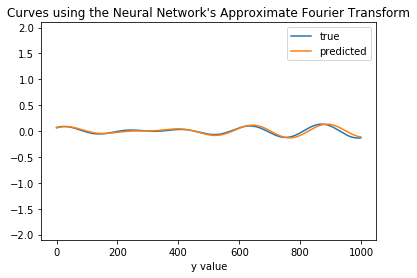

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.07428105 0.72646505 0.05996389 0.9045143 ]


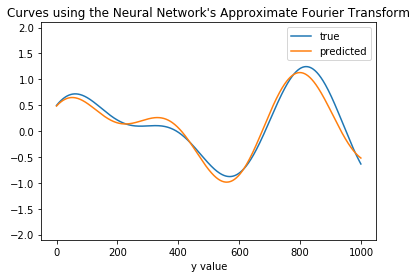

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.67884725 0.3025828  0.4837403  0.5086932 ]


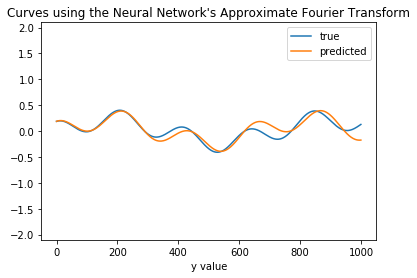

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.22247212 0.3016072  0.18857992 0.91686857]


In [15]:
# your code here
plot_predictions(model,X_test,y_test)

In [16]:
model.evaluate(X_test,y_test)

2000/2000 [==============================] - 0s 31us/step


0.019832794517278672

----
**Your answer here**




The model is, in most cases, doing a very good job pinning down the correct coefficients. It seems to be making numerical errors on the order of +/- .02, and this error decreases with further training. The model has a total loss of 0.3, in line with the training and validation error. It looks like the model has learned the mapping from data to the coefficients that generated the data.

----

**1.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

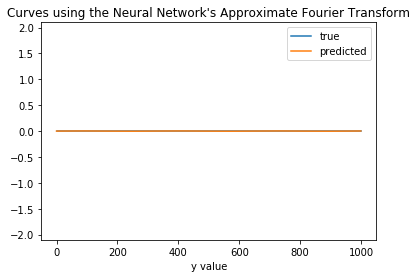

true: [0. 0. 0. 0.]
predicted: [ 2.6761033e-03  6.2313390e-01 -1.6679848e-04  3.3564696e-01]


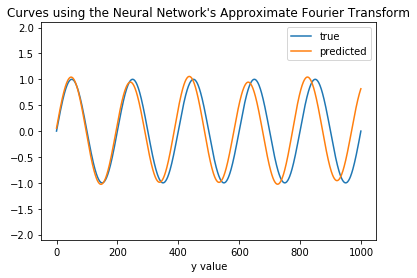

true: [1. 1. 0. 0.]
predicted: [0.99884915 1.031462   0.0566965  0.45954075]


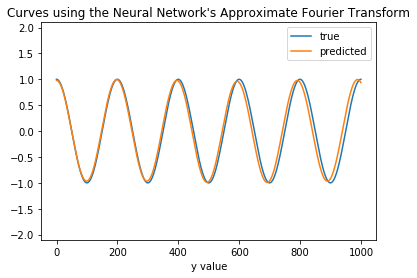

true: [0. 0. 1. 1.]
predicted: [0.01692777 0.25067067 0.9787108  1.0110791 ]


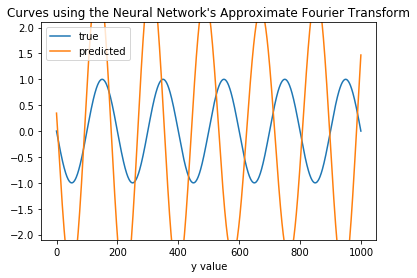

true: [-1.  1.  0.  0.]
predicted: [ 2.6957123 -1.1188352  0.3465995  1.3468574]


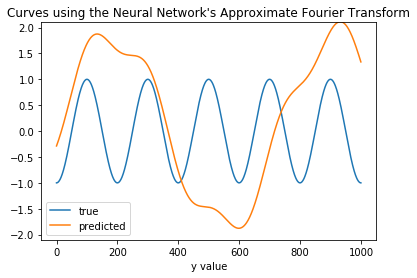

true: [ 0.  0. -1.  1.]
predicted: [ 1.8551521   0.27302647 -0.28715095  0.9560814 ]


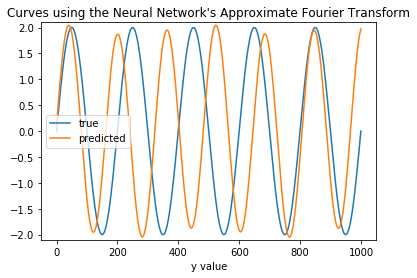

true: [2. 1. 0. 0.]
predicted: [1.9554992  1.2409234  0.0988507  0.40893388]


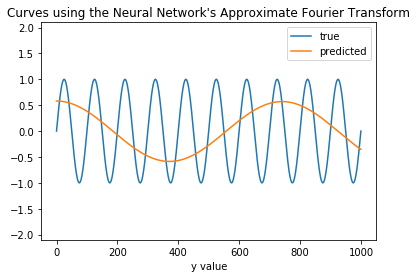

true: [1. 2. 0. 0.]
predicted: [ 0.05570632 -0.00862285  0.58092564  0.26969996]


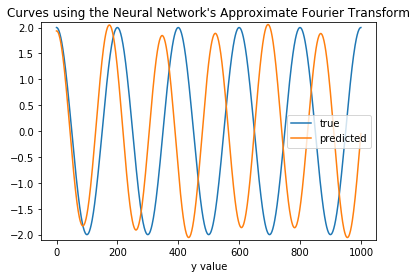

true: [0. 0. 2. 1.]
predicted: [0.12433852 0.36031786 1.9338071  1.1511521 ]


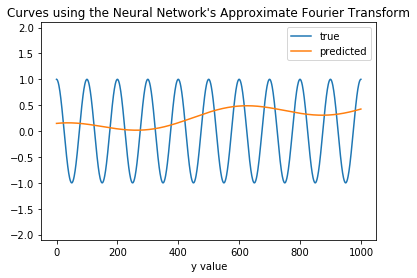

true: [0. 0. 1. 2.]
predicted: [0.5653351  0.03367662 0.14838752 0.33511424]


In [17]:
# your code here
plot_predictions(model,X_extended_test,y_extended_test)

----
**Your answer here**



The model does well on examples with coefficients in the range $[0,1]$ but struggles when coefficients are negative or bigger than 1.

----

**1.8** Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

----
**Your answer here**


The model is struggling to accurately predict answers on data outside the examples given in training. Even so, it is easily able to provide correct answers for new data _from the same distribution as the training data_. The network is not overfit nor underfit- it performs equally well on its training data as on held-out test data.

However, although the model learned _a_ rule for mapping from its training input to the example outputs, it did not learn the rule we had in mind, and the model does not extend beyond the kinds of examples it was trained on.  This is a form of extrapolation.

**Instructor's note**: This is a common theme with neural networks and other black-box learners: they will figure out a rule that works on the data they are trained on, but that rule is unlikely to extend beyond the range of the training examples. Collecting good data is the most important analytic step!
----

<hr style='height:2pt'>

## Regulrizing Neural Networks

In this problem set we have already explored how ANN are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size), and how well the neural network can generalize. In this problem we focus on issues of overfitting and regularization in Neural Networks.

As we have explained in class, ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns don't generalize to fresh data.

There are several methods used to improve ANN generalization. One approach is to use an achitecutre just barely wide/deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and computationally costly to hunt for a correct size. Given this, other methodologies are used to fight overfitting and improve the ANN generalization. These, like other techniques to combat overfitting, fall under the umbrella of Regularization.

In this problem you are asked to regularize a network given to you below. The train dataset can be generated using the code also given below. 




<div class='exercise'> <b> Question 2 [50 pts] </b> </div>


**2.1** ** Data Download and Exploration**:  For this problem, we will be working with the MNIST dataset (Modified National Institute of Standards and Technology database) which is a large database of handwritten digits and commonly used for training various image processing systems. We will be working directly with the download from `keras MNIST dataset` of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

Please refer to the code below to process the data.

For pedagogical simplicity, we will only use the digits labeled `4` and `9`, and we want to use a total of 800 samples for training.

**2.2 Data Exploration and Inspection:** Use `imshow` to display a handwritten 4 and a handwritten 9.

**2.3 Overfit an ANN:** Build a fully connected network (FCN) using `keras`: 

1. Nodes per Layer: 100,100,100,2 (<-the two-class 'output' layer)
2. Activation function: reLU 
3. Loss function: binary_crossentropy
4. Output unit: Sigmoid 
5. Optimizer: sgd (use the defaults; no other tuning)
6. Epochs: no more than 2,000
7. Batch size: 128
8. Validation size: .5

This NN trained on the dataset you built in 2.1 will overfit to the training set. Plot the training accuracy and validation accuracy as a function of epochs and explain how you can tell it is overfitting. 

**2.4 Explore Regularization**: Your task is to regularize this FCN. You are free to explore any method or combination of methods. If you are using anything besides the methods we have covered in class, give a citation and a short explanation. You should always have an understanding of the methods you are using. 

Save the model using `model.save(filename)` and submit in canvas along with your notebook. 

We will evaluate your model on a test set we've kept secret. 

1. Don't try to use extra data from NMIST. We will re-train your model on training set under the settings above. 
2. Keep the  architecture above as is. In other words keep the number of layers, number of nodes, activation function, and loss fucntion the same. You can change the number of epochs (max 2000), batch size, optimizer and of course add elements that can help to regularize (e.g. drop out, L2 norm etc). You can also do data augmentation. 
3. You *may* import new modules, following the citation rule above.

Grading: Your score will be based on how much you can improve on the test score via regularization:
1.  (0-1] percent will result into 10 pts
2.  (1-2] percent will result into 20 pts
3.  (2-3] percent will result into 30 pts
4.   Above 3 percent will result in 35 pts
6.   Top 15 groups or single students will be awarded an additional 10 pts
7.   The overall winner(s) will be awarded an additional 5 pts

**2.1** ** Data Download and Exploration**:  For this problem, we will be working with the MNIST dataset (Modified National Institute of Standards and Technology database) which is a large database of handwritten digits and commonly used for training various image processing systems. We will be working directly with the download from `keras MNIST dataset` of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

Please refer to the code below to process the data.

For pedagogical simplicity, we will only use the digits labeled `4` and `9`, and we want to use a total of 800 samples for training.

In [3]:
## Read and Setup train and test splits in one
from keras.datasets import mnist 
from random import randint 

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

#shuffle the data before we do anything
x_train, y_train = shuffle(x_train, y_train, random_state=1)

In [4]:
## separating 4s and 9s select 800 points 
# your code here 
class1 = 4
class2 = 9
idx_tr  = (y_train == class1) | (y_train==class2)
idx_te  = (y_test == class1) | (y_test==class2)

## building the train and test set needed by 4s and 9s

x_train= x_train[idx_tr, :, :]
x_test= x_test[idx_te, :, :] 
y_train= y_train[idx_tr]
y_test= y_test[idx_te] 

 
n_train = 800
n_test = 800 

x_train= x_train[:n_train, :, :]
x_test= x_test[:n_test, :, :]
y_train= y_train[:n_train]
y_test= y_test[:n_test]



## making it a binary class problem
y_train[y_train==class1] = 0 
y_train[y_train==class2] = 1
y_test[y_test==class1] = 0 
y_test[y_test==class2] = 1 

In [5]:
# Preprocess data using keras.utils.to_categorical
# your code here 
num_classes = 2 

## flatten images
image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)

## Convertion class vectors ---> binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [6]:
# scale the data otherwise reLU can become unstable 
# your code here 
x_train = ((x_train-x_train.mean(axis=1).reshape(-1,1))/(x_train.std(axis=1).reshape(-1,1)))
x_test = ((x_test-x_test.mean(axis=1).reshape(-1,1))/(x_test.std(axis=1).reshape(-1,1)))

**2.2 Data Exploration and Inspection:** Use `imshow` to display a handwritten 4 and a handwritten 9.

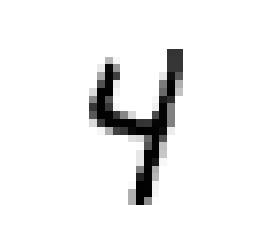

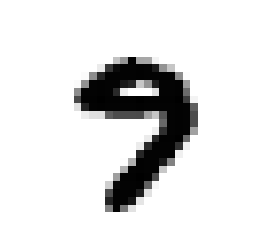

In [7]:
# your code here

x_train.shape, x_test.shape, y_train.shape, y_test.shape

plt.axis('off')
plt.imshow(x_train.reshape(-1, 28,28)[2], cmap='Greys')
plt.show()
plt.axis('off')
plt.imshow(x_train.reshape(-1, 28,28)[1], cmap='Greys')

**2.3 Overfit an ANN:** Build a fully connected network (FCN) using `keras`: 

1. Nodes per Layer: 100,100,100,2 (<-the two-class 'output' layer)
2. Activation function: reLU
3. Loss function: binary_crossentropy
4. Output unit: Sigmoid 
5. Optimizer: sgd (use the defaults; no other tuning)
6. Epochs: no more than 1,000
7. Batch size: 128
8. Validation size: .5

This NN trained on the dataset you built in 2.1 will overfit to the training set. Plot the training accuracy and validation accuracy as a function of epochs and explain how you can tell it is overfitting. 

In [8]:
# your code here

batch_size = 32
epochs = 1000

num_classes = 2 

nodes_layers =[100,100, 100] 

#reset the model 
model = Sequential()

# input layers 
model.add(Dense(nodes_layers[0], activation='relu', input_shape=(784,)))

# hidden layers 
for s in nodes_layers[1:]:
        model.add(Dense(units = s,  activation = 'relu'))

# output layer 
model.add(Dense(units=num_classes,  activation='sigmoid'))


# Summary 
#model.summary()

# compile it 
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])

# fit it 

history_basic = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,  validation_split=.5, verbose=False)#False

#save the model 

loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)


Test loss: 0.216
Test accuracy: 0.948


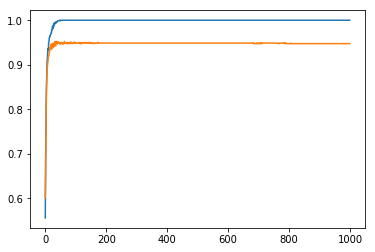

In [9]:
#your code here
plt.plot(history_basic.history['acc'])
plt.plot(history_basic.history['val_acc'])

print()
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

<hr>

Your answer here


The complexity of the network introduces more complex functions that can pick up the specificity of the image data presented to the network for training. We can see that as the training curve, shows  1 for learning, as the ANN is incorporating and fitting higher resolution features from the images that are not necessarily needed when for example we are trying to distinguish between any digits-recognition, in this case the digits 4 and 9.
Here we can see the situation of overfitting where, in this case the ANN has been able to learn in specificity the patterns present in the training data, however it is unable to learn as to how to generalize that same learning to new data, seen in the validation curve and test score.

<hr>

**2.4 Explore Regularization**: Your task is to regularize this FCN. You are free to explore any method or combination of methods. If you are using anything besides the methods we have covered in class, give a citation and a short explanation. You should always have an understanding of the methods you are using. 

Save the model using `model.save(filename)` and submit in canvas along with your notebook. 


**We will provide several different solutions from our staff and students**

<hr>

CS109A Solution

In [10]:
# your code here
from keras import regularizers
import time

from keras.layers import Dropout
from keras.constraints import maxnorm

''' create_dense() 
    
    @params 
        array: layer sizes, 
    
    @returns
        Keras model, fully connected ANN with layer sizes specified per array. 
        eg: create_dense([32, 64, 128]) returns deeply connected ANN with 3 hidden layers: 
            1st: 32 nodes, 
            2nd: 64 nodes, 
            3rd: 128 nodes.
    
    Global Variable usage:
        * image_size ===> assumes input data = 784 unit vector
    
    ANN
        layers activation:
            * input and hidden ---> sigmoid
            * output ---> softmax
        regularization @ all layers
            * kernel_regularizer=regularizers.l2(0.001)


'''



def create_dense1(layer_sizes, l2=0.01):
    model = Sequential()
    
    model.add(Dropout(0.2, input_shape=(image_size,)))

    for s in layer_sizes[1:]:
        print(s)
        model.add(Dense(units = s, 
                        activation = 'sigmoid',
                        kernel_constraint=maxnorm(2)))
    
        
    model.add(Dense(units=num_classes, activation='softmax'))

    return model


#####################################################################################


## coding early stopping callback
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                              patience=10, verbose=0, mode='auto')






#####################################################################################

'''  evaluate_es(); prints model summary + 
                learns model + 
                prints accruracy on test and train + 
    
    @params
        model: from create_dense()
        batch_size; can be respecified, set @ 128
        epochs; can be respecified, set @5
        
    Global Variable usage:
        MNIST dataset preprocessed above
        earlyStopping callback above

'''

def evaluate_es(model, batch_size=128, epochs=5, filename=""):
    start_time = time.time()
    model.summary()
    model.compile(optimizer='sgd', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    
        
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        #callbacks=[earlyStopping],
                        validation_split=.1, 
                        verbose=False)#False
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
    
    if filename!="": model.save(filename) 
        
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    print()
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')
    
    print()
    elapsed_time = time.time() - start_time
    print("Training time:",elapsed_time)





100
100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_10 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_33 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 202       
Total params: 88,802
Trainable params: 88,802
Non-trainable params: 0
_________________________________________________________________


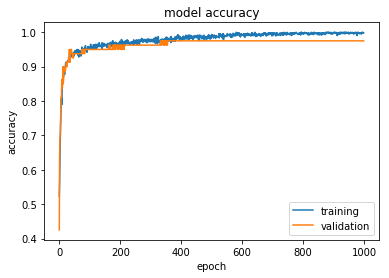


Test loss: 0.113
Test accuracy: 0.971

Training time: 43.66434717178345


In [20]:
evaluate_es(create_dense1([100,100,100]),32,1000,"model_dropout_input_norm2.h5")

<hr>

Student Solution : *Yuting Kuo*

In [21]:
## Read and Setup train and test splits in one
from keras.datasets import mnist 
from random import randint 

(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data() 

#shuffle the data before we do anything
x_train2, y_train2 = shuffle(x_train2, y_train2, random_state=11)

In [22]:
## separating 4s and 9s select 800 points 
# your code here 
train_4=x_train2[y_train2==4]
train_9=x_train2[y_train2==9]

# randomly select 800 points (because we shuffle first, so we can choose first 400)
train_4s=train_4[:400]
train_9s=train_9[:400]

test_4s=x_test2[y_test2==4]
test_9s=x_test2[y_test2==9]

# Preprocess data using keras.utils.to_categorical
# your code here 

x_train_simply=np.concatenate((train_4s,train_9s))
y_train_simply=np.concatenate((y_train2[y_train2==4][:400],y_train2[y_train2==9][:400]))

x_test_simply=np.concatenate((test_4s,test_9s))
y_test_s=np.concatenate((y_test2[y_test2==4],y_test2[y_test2==9]))


# let y=0 equals to 4, y=1 equals to 9
y_train_simply[y_train_simply==4]=0
y_train_simply[y_train_simply==9]=1

y_test_s[y_test_s==4]=0
y_test_s[y_test_s==9]=1


y_train_simply=keras.utils.to_categorical(y_train_simply)
y_test_simply=keras.utils.to_categorical(y_test_s)

# scale the data otherwise reLU can become unstable 
# your code here 
x_train_simply=x_train_simply/x_train_simply.max()
x_test_simply=x_test_simply/x_test_simply.max()

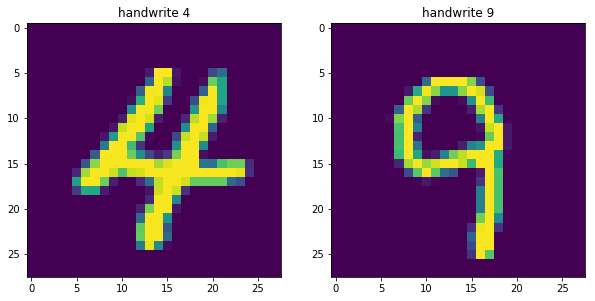

In [23]:
## 2.2 Data Exploration and Inspection:
# your code here
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_train_simply[0])
plt.title('handwrite 4')
plt.subplot(1,2,2)
plt.imshow(x_train_simply[-1])
plt.title('handwrite 9')
x_train_simply, y_train_simply = shuffle(x_train_simply, y_train_simply, random_state=1)

Train set accuracy rate is 100.00%
Validation set accuracy rate is 94.75%
1991/1991 [==============================] - 0s 25us/step
Test set accuracy rate is 94.68%


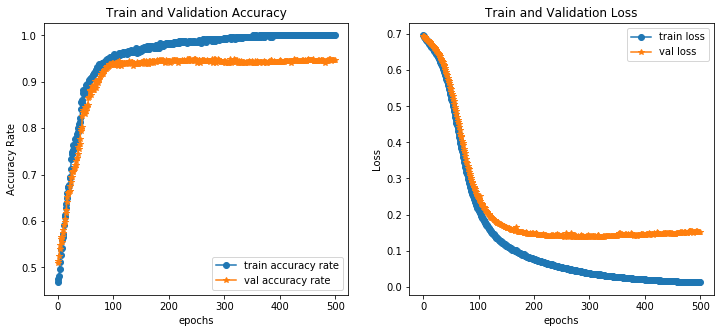

In [26]:
## 2.3 Overfit an ANN:

# resize
x_train_simply=x_train_simply.reshape([800,-1])

x_test_simply=x_test_simply.reshape([-1,28*28])

# train validation split
X_train_reg2, X_val_reg2, y_train_reg2, y_val_reg2 = train_test_split(
    x_train_simply, y_train_simply, test_size=0.5, random_state=0)

# your code here
trials2 = {} 

# reset the model 
nn_model2 = Sequential()

# two layer
nn_model2.add(
    Dense(100, activation='relu',input_shape=(x_train_simply.shape[1],)))
nn_model2.add(
    Dense(100, activation='relu'))
nn_model2.add(
    Dense(100, activation='relu'))
nn_model2.add(
    Dense(2, activation='sigmoid'))

# compile it 
nn_model2.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['accuracy'])

batch_size = 128
epochs = 500

# fit
trials2['linreg'] = nn_model2.fit(
    X_train_reg2, y_train_reg2,batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_reg2, y_val_reg2), verbose=False)

#your code here
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Train and Validation Accuracy')
plt.plot(trials2['linreg'].history['acc'], '-o', label = 'train accuracy rate')
plt.plot(trials2['linreg'].history['val_acc'], '-*', label = 'val accuracy rate')
plt.xlabel('epochs')
plt.ylabel('Accuracy Rate')
plt.legend();

plt.subplot(1,2,2)
plt.title('Train and Validation Loss')
plt.plot(trials2['linreg'].history['loss'], '-o', label = 'train loss')
plt.plot(trials2['linreg'].history['val_loss'], '-*', label = 'val loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend();


print('Train set accuracy rate is {0:.2%}'.format(trials2['linreg'].history['acc'][-1]))

print('Validation set accuracy rate is {0:.2%}'.format(trials2['linreg'].history['val_acc'][-1]))

print('Test set accuracy rate is {0:.2%}'.format(nn_model2.evaluate(x_test_simply,y_test_simply)[1]))

The confusion matrix is as follows:

In [27]:
ypredict=list(map(np.argmax,nn_model2.predict(x_test_simply)))
result=pd.DataFrame(confusion_matrix(y_test_s,ypredict),columns=['predict 4','predict 9'])
result.index=['true 4','true 9']
result

predict 4  predict 9
true 4        931         51
true 9         55        954



**Your answer here**

It is overfitting because the accuracy rate in training set already reach 100%, and it performs not that great on validation set. When epochs larger than 100, the training set accuracy increase till 100% while validation set remains the same. Therefore I can tell the model is already overfit when epoches larger than 100. 

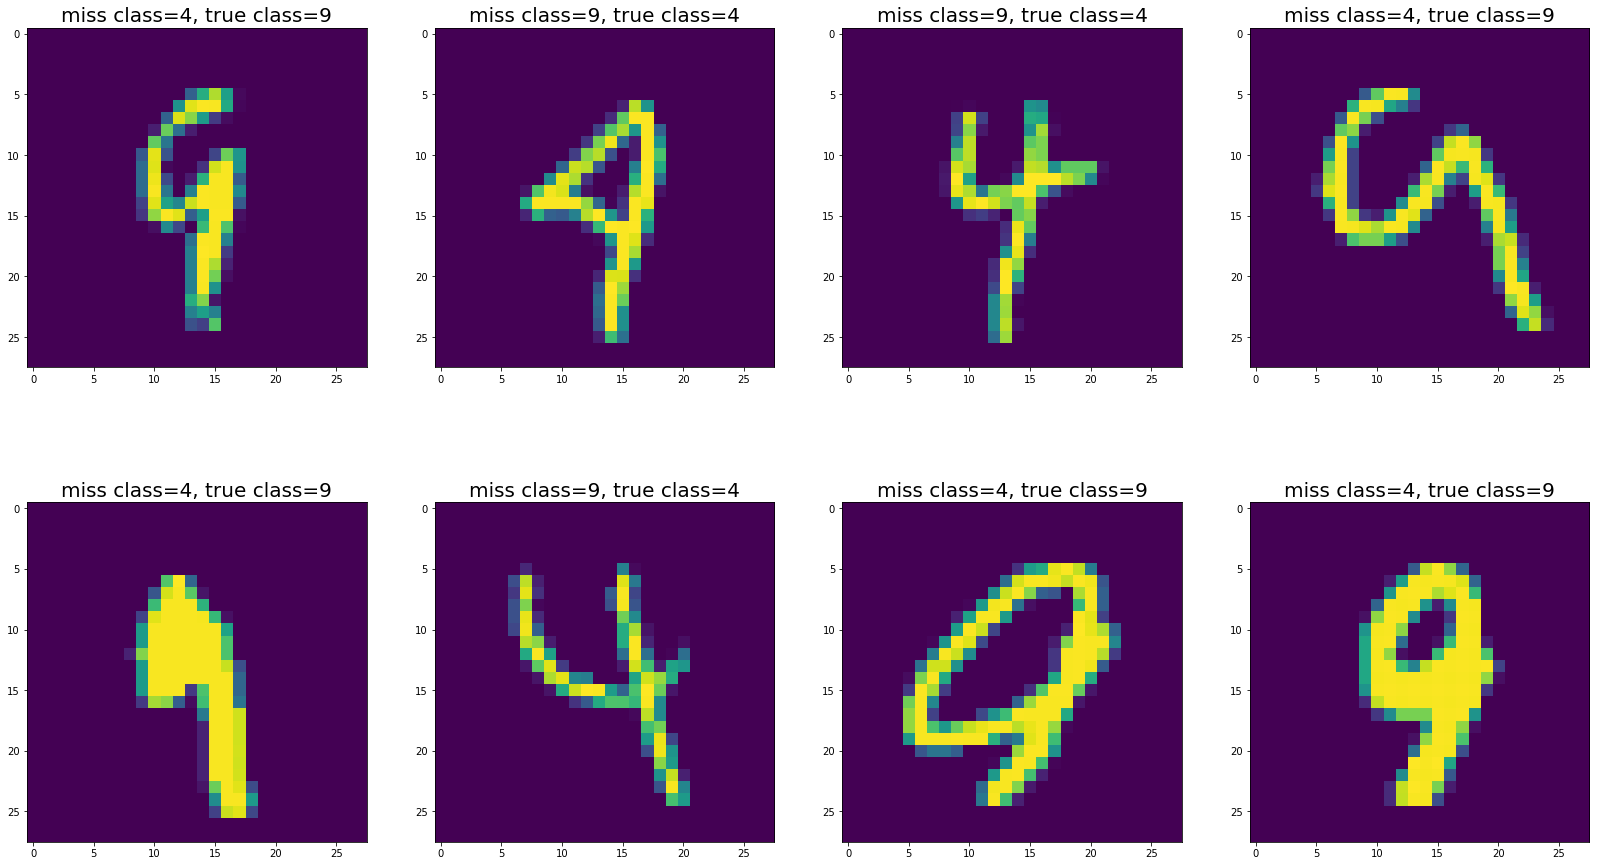

In [28]:
def plot_missclass(model):
    y_val_predict=list(map(np.argmax,model.predict(X_val_reg2)))
    y_val_predict=keras.utils.to_categorical(y_val_predict)
    X_val_missclass=X_val_reg2[~((y_val_predict==y_val_reg2).all(axis=1))]
    X_val_missclass=X_val_missclass.reshape(-1,28,28)
    y_val_missclass=np.ones(len(X_val_missclass))
    y_val_trueclass=np.ones(len(X_val_missclass))
    y_val_missclass[(y_val_predict[~((y_val_predict==y_val_reg2).all(axis=1))]==[0,1]).all(axis=1)]=9
    y_val_missclass[(y_val_predict[~((y_val_predict==y_val_reg2).all(axis=1))]==[1,0]).all(axis=1)]=4
    y_val_trueclass[(y_val_reg2[~((y_val_predict==y_val_reg2).all(axis=1))]==[0,1]).all(axis=1)]=9
    y_val_trueclass[(y_val_reg2[~((y_val_predict==y_val_reg2).all(axis=1))]==[1,0]).all(axis=1)]=4

    plt.figure(figsize=(28,16))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(X_val_missclass[i])
        plt.title('miss class={0:.0f}, true class={1:.0f}'.format(y_val_missclass[i],y_val_trueclass[i]),fontsize=20)


plot_missclass(nn_model2)

In the validation set, the model becomes more difficult to recognize true 4. So I can use this result to change my data generation direction.

Train set accuracy rate is 97.49%
Validation set accuracy rate is 97.75%
1991/1991 [==============================] - 0s 24us/step
Test set accuracy rate is 96.89%


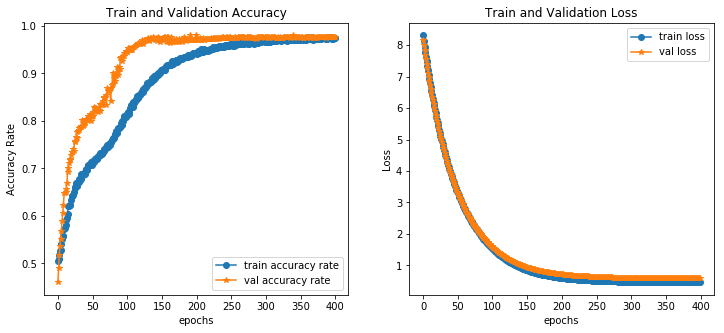

In [30]:
##2.4 Explore Regularization**: 

## data generation for making more picture of translation invariant.

# data augmentation
from keras.preprocessing.image import ImageDataGenerator
def data_augment(X_train_reg2,y_train_reg2,n=10):
    '''input number 32*n of target increase picture, return picture with new generated 32*n'''
    datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        width_shift_range=0.10,
        rotation_range=40,
        height_shift_range=0.10,
        shear_range=0.1,
        zoom_range=0.6)

    # increase the X_train_reg2 using data augmentation
    if len(X_train_reg2.shape)!=3:
        X_train_reg2=X_train_reg2.reshape(-1,28,28)
    X_train_reg3=np.expand_dims(X_train_reg2,axis=3)
    datagen.fit(X_train_reg3)
    aug=datagen.flow(X_train_reg3,y_train_reg2)

    i=1
    while i<=n:
        x_new,y_new=next(aug)
        x_new=x_new.reshape(-1,28,28)
        X_train_reg2=np.concatenate((X_train_reg2,x_new))
        y_train_reg2=np.concatenate((y_train_reg2,y_new))
        i+=1
    X_train_reg2 = X_train_reg2.reshape(-1,28*28)
    return X_train_reg2,y_train_reg2

# your code here

# bootstrap more 9 because last time tuning parameters, I found my model3 misclassified more 4 than 9.
where9=(y_train_reg2==[1,0]).all(axis=1)
bootstrap=np.random.choice(range(sum(where9)),30)
X_train_reg3=np.concatenate((X_train_reg2,X_train_reg2[where9][bootstrap]))
y_train_reg3=np.concatenate((y_train_reg2,y_train_reg2[where9][bootstrap]))

# data augmentation
X_train_reg3,y_train_reg3=data_augment(X_train_reg3,y_train_reg3,200)


batch_size = 256
epochs = 400



# reset the model 
nn_model3 = Sequential()

# add regularization
nn_model3.add(
    Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.02),
               ))


nn_model3.add(
    Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
nn_model3.add(Dropout(0.3))
nn_model3.add(
    Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
nn_model3.add(Dropout(0.3))
nn_model3.add(
    Dense(2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.02)))


# compile it 
nn_model3.compile(loss='binary_crossentropy', optimizer='sgd',metrics=['accuracy'])

#earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='auto')
# fit
trials2['regularization'] = nn_model3.fit( 
    X_train_reg3, y_train_reg3,batch_size=batch_size,
    epochs=epochs,#callbacks=[earlyStopping],
    validation_data=(X_val_reg2, y_val_reg2), verbose=False)
nn_model3.save('regular_model')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Train and Validation Accuracy')
plt.plot(trials2['regularization'].history['acc'], '-o', label = 'train accuracy rate')
plt.plot(trials2['regularization'].history['val_acc'], '-*', label = 'val accuracy rate')
plt.xlabel('epochs')
plt.ylabel('Accuracy Rate')
plt.legend();

plt.subplot(1,2,2)
plt.title('Train and Validation Loss')
plt.plot(trials2['regularization'].history['loss'], '-o', label = 'train loss')
plt.plot(trials2['regularization'].history['val_loss'], '-*', label = 'val loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend();

print('Train set accuracy rate is {0:.2%}'.format(trials2['regularization'].history['acc'][-1]))

print('Validation set accuracy rate is {0:.2%}'.format(trials2['regularization'].history['val_acc'][-1]))

print('Test set accuracy rate is {0:.2%}'.format(nn_model3.evaluate(x_test_simply,y_test_simply)[1]))

Confusion matrix is:

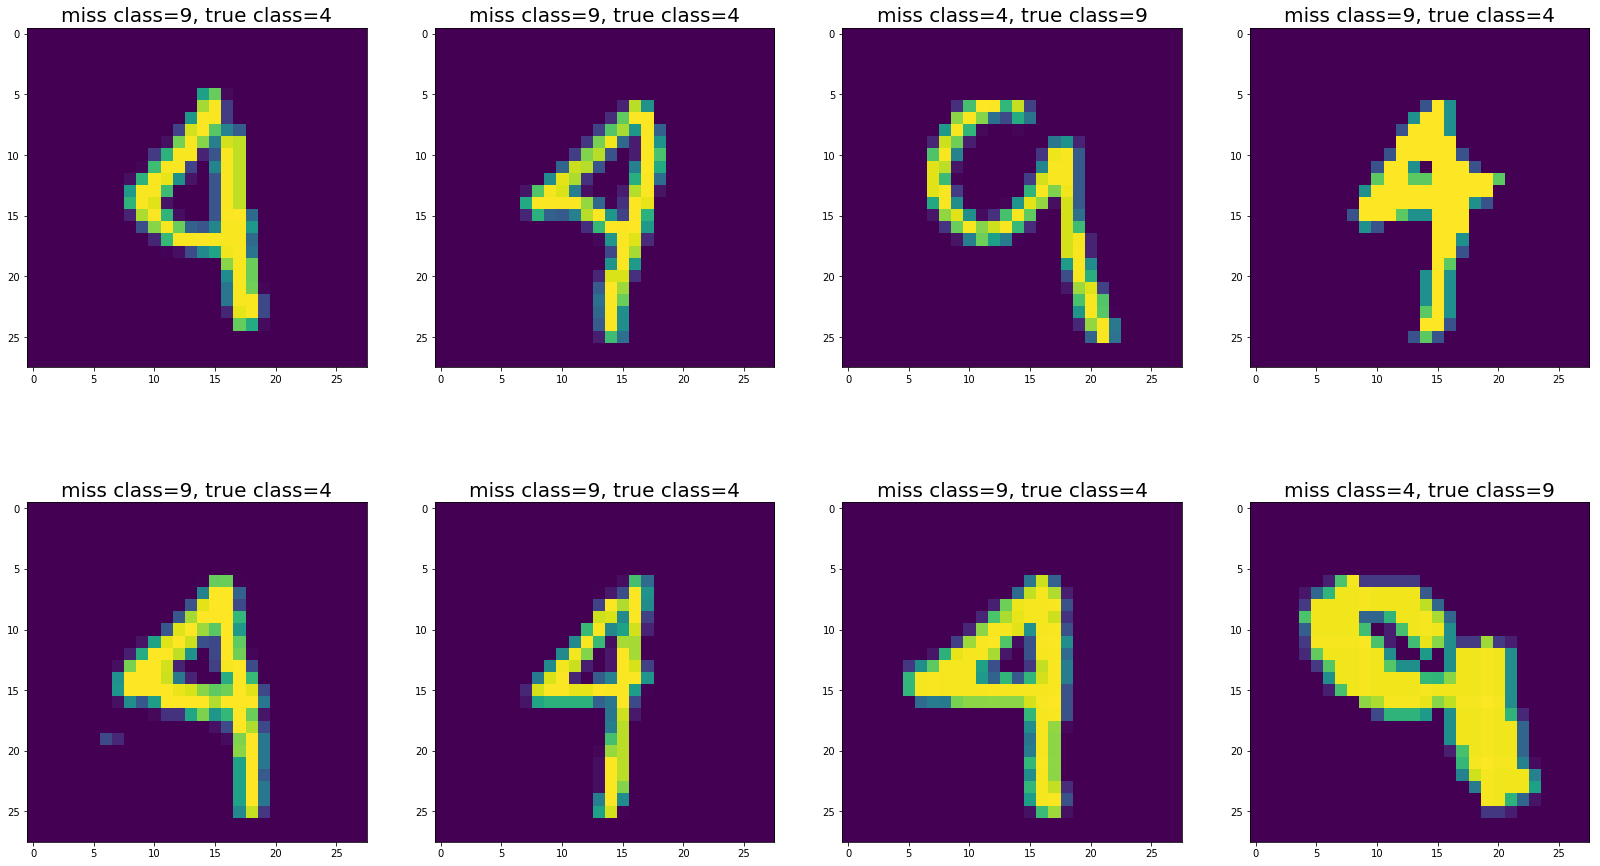

In [31]:
ypredict=list(map(np.argmax,nn_model3.predict(x_test_simply)))
result=pd.DataFrame(confusion_matrix(y_test_s,ypredict),columns=['predict 4','predict 9'])
result.index=['true 4','true 9']
result

#plot which picture incorrectly classified using only validation set.

plot_missclass(nn_model3)

nn_model3.save('my_model.h5') 

I am satisfied with my model. Because, look at the picture we misclassified, I can hardly tell 4 with 9, let alone the machine. 

My model increase a lot: improve 3% in test set

overfit model:
- train 100%
- val  95.38%
- test 94.78%

my regularization model
- train  97.65%
- val  98.00%
- test 97.64%

<hr>

Student Solution: *Manish Reddy Vuyyuru*

In [32]:
## Read and Setup train and test splits in one
from keras.datasets import mnist 
from random import randint 

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

#shuffle the data before we do anything
x_train, y_train = shuffle(x_train, y_train, random_state=1)

## separating 4s and 9s select 800 points 
x_train_subset = x_train[(y_train == 4) | (y_train == 9)][:800]
y_train_subset = y_train[(y_train == 4) | (y_train == 9)][:800]

In [33]:
#reassign, 4-> 0, 9->1
y_train_subset[y_train_subset == 4] = 0
y_train_subset[y_train_subset == 9] = 1

In [34]:
# Preprocess data using keras.utils.to_categorical
y_train_subset = keras.utils.to_categorical(y_train_subset, num_classes=2)

In [38]:
# scale the data otherwise reLU can become unstable 
n_samples, dim_x, dim_y = x_train_subset.shape 
flat_x_train_subset = x_train_subset.reshape((n_samples, dim_x*dim_y))
scaled_flat_x_train_subset = scale(flat_x_train_subset)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


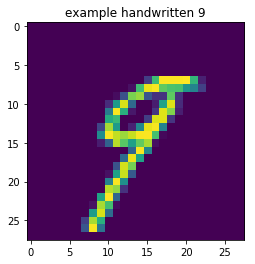

In [39]:
## Exploration

plt.imshow(x_train_subset[0])
plt.title('example handwritten 9')
plt.show()

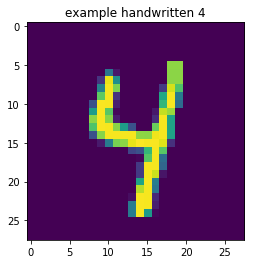

In [40]:
plt.imshow(x_train_subset[2])
plt.title('example handwritten 4')
plt.show()

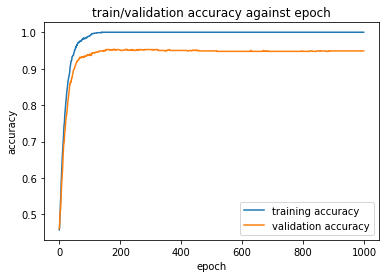

In [43]:
## Overfit ANN

scaled_flat_x_train_subset[0].shape[0]

model = Sequential()

model.add(Dense(units=100, activation='relu', input_shape=(scaled_flat_x_train_subset[0].shape[0],)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))

sgd = SGD()
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
history = model.fit(x=scaled_flat_x_train_subset, y=y_train_subset, batch_size=128, 
                    epochs=1000, validation_split=0.5, verbose=0)                    


plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('train/validation accuracy against epoch')
plt.show()

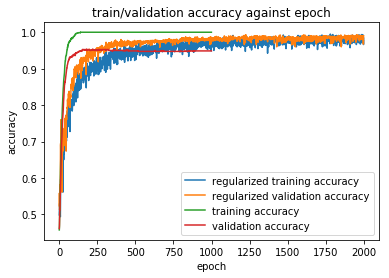

val accuracy improvement:0.04125000953674318.
evaluation took 221.90409970283508s.


In [44]:
## Regularization

#image augmentation
#no regularization method tried below seems to work anywhere near as well as augmenting the training data
tlen = len(x_train_subset)

x_train_subset = x_train_subset[int(tlen/2):] #get last 0.5 of x_train_subset, per validation_split docs for keras
x_test_subset = x_train_subset[:int(tlen/2)]
y_train_subset = y_train_subset[int(tlen/2):]
y_test_subset = y_train_subset[:int(tlen/2)]

x_test_subset = x_test_subset.reshape(x_test_subset.shape[0], 28, 28, 1)
x_train_subset = x_train_subset.reshape(x_train_subset.shape[0], 28, 28, 1)


model = Sequential()

dropout_freq = 0.0
kernel_weight = 0.01
bias_weight = 0.01
activity_weight = 0.0

# learningrate = 0.01
# momentum = 0.0
# decay = 0.00001
# nesterov = False

batch_size = 200

sTime = time.time()

model.add(Reshape((784,), input_shape=(28,28,1)))
model.add(Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(kernel_weight), bias_regularizer=regularizers.l2(bias_weight), activity_regularizer=regularizers.l2(activity_weight)))
model.add(Dropout(dropout_freq))
model.add(Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(kernel_weight), bias_regularizer=regularizers.l2(bias_weight), activity_regularizer=regularizers.l2(activity_weight)))
model.add(Dropout(dropout_freq))
model.add(Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(kernel_weight), bias_regularizer=regularizers.l2(bias_weight), activity_regularizer=regularizers.l2(activity_weight)))
model.add(Dropout(dropout_freq))
model.add(Dense(units=2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=SGD(), metrics=['accuracy'])
datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=10, width_shift_range=0.2, height_shift_range=0.2)
datagen.fit(x_train_subset)
reg_history = model.fit_generator(datagen.flow(x_train_subset, y_train_subset, batch_size=batch_size), steps_per_epoch=x_train_subset.shape[0] // batch_size, epochs=2000, verbose=0, validation_data=(x_test_subset, y_test_subset))

plt.plot(reg_history.history['acc'], label='regularized training accuracy')
plt.plot(reg_history.history['val_acc'], label='regularized validation accuracy')
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('train/validation accuracy against epoch')
plt.show()                
print('val accuracy improvement:{}.'.format(reg_history.history['val_acc'][-1] - history.history['val_acc'][-1]))
print('evaluation took {}s.'.format(time.time() - sTime))

<hr>